In [1]:
import numpy as np
import pandas as pd
import vector
import os
import awkward as ak
vector.register_awkward()

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# mplhep for CMS-style plots
import mplhep as hep
import hist
from coffea.hist.plot import clopper_pearson_interval

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 16})

/Users/billyli/miniforge_x86_new/envs/hh4b/lib/python3.9/site-packages/coffea/util.py:154: FutureWarning: In coffea version v2023.3.0 (target date: 31 Mar 2023), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [3]:
# set up directory to save plots
plot_dir = "../../../plots/MatchingStudy/23Aug18/"
_ = os.system(f"mkdir -p {plot_dir}")

In [4]:
events = pd.read_parquet(
    "../../../parquet/out_0.parquet"
    # "/eos/uscms/store/user/cmantill/bbbb/matching/Aug8/2022/GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_TSG/parquet"
)

In [5]:
events.keys().to_numpy()

array([('GenHiggsEta', 0), ('GenHiggsEta', 1), ('GenHiggsPhi', 0),
       ('GenHiggsPhi', 1), ('GenHiggsMass', 0), ('GenHiggsMass', 1),
       ('GenHiggsPt', 0), ('GenHiggsPt', 1), ('GenbEta', 0),
       ('GenbEta', 1), ('GenbEta', 2), ('GenbEta', 3), ('GenbPhi', 0),
       ('GenbPhi', 1), ('GenbPhi', 2), ('GenbPhi', 3), ('GenbMass', 0),
       ('GenbMass', 1), ('GenbMass', 2), ('GenbMass', 3), ('GenbPt', 0),
       ('GenbPt', 1), ('GenbPt', 2), ('GenbPt', 3),
       ('ak4JetHiggsMatch', 0), ('ak4JetHiggsMatch', 1),
       ('ak4JetHiggsMatch', 2), ('ak4JetHiggsMatch', 3),
       ('ak4JetHiggsMatch', 4), ('ak4JetHiggsMatch', 5),
       ('ak4JetHiggsMatchIndex', 0), ('ak4JetHiggsMatchIndex', 1),
       ('ak4JetHiggsMatchIndex', 2), ('ak4JetHiggsMatchIndex', 3),
       ('ak4JetHiggsMatchIndex', 4), ('ak4JetHiggsMatchIndex', 5),
       ('ak8FatJetHiggsMatch', 0), ('ak8FatJetHiggsMatch', 1),
       ('ak8FatJetHiggsMatch', 2), ('ak8FatJetHiggsMatchIndex', 0),
       ('ak8FatJetHiggsMatchInde

In [6]:
def make_vector(events: pd.DataFrame, obj: str):
    """Create a ``vector`` object from the columns of the dataframe"""
    mstring = "Msd" if obj == "ak8FatJet" else "Mass"

    return vector.array(
        {
            "pt": events[f"{obj}Pt"],
            "phi": events[f"{obj}Phi"],
            "eta": events[f"{obj}Eta"],
            "M": events[f"{obj}{mstring}"],
        }
    )

In [7]:
gen_higgs = make_vector(events, "GenHiggs")
# gen_bs shape: [# events, # Higgs (2), # b's (2)]
gen_bs = make_vector(events, "Genb").reshape(-1, 2, 2)

# sort higgs by pT
pt_argsort = np.argsort(gen_higgs.pt, axis=1)[:, ::-1]
gen_higgs = np.take_along_axis(gen_higgs, pt_argsort, 1)
# need to use np.newaxis to have same # of dimensions as gen_higgs (broadcasting)
gen_bs = np.take_along_axis(gen_bs, pt_argsort[..., np.newaxis], 1)
bh_dR = gen_bs.deltaR(gen_higgs[..., np.newaxis])
bs_dR = gen_bs[:, :, 0].deltaR(gen_bs[:, :, 1])

### Matching gen b quarks to H

In [8]:
matching_dR = 1
num_gen_bs_close = np.sum(bs_dR < matching_dR, axis=1)

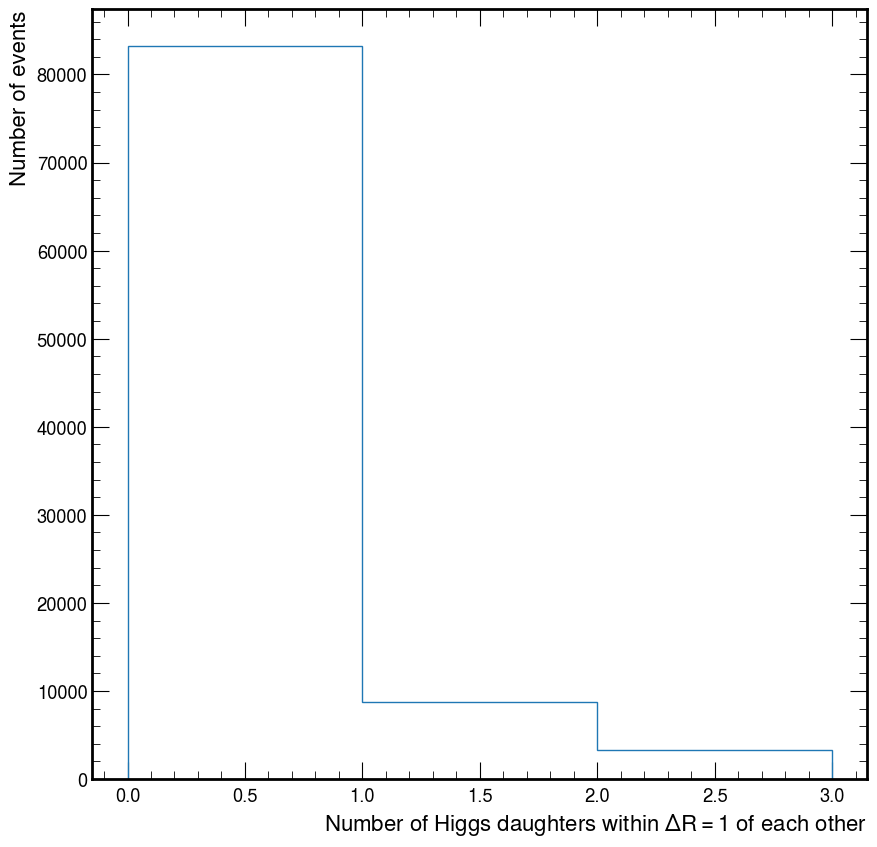

In [9]:
plt.hist(num_gen_bs_close, [0, 1, 2, 3], histtype="step")
plt.ylabel("Number of events")
plt.xlabel(r"Number of Higgs daughters within $\Delta R = 1$ of each other")
plt.savefig(f"{plot_dir}/matching_dr1.pdf")
plt.show()

### Plots

In [10]:
def plot_higgs_hist(vals: np.ndarray, bins: np.ndarray, xlabel: str, filename: str):
    fig, ax = plt.subplots(figsize=(10, 8))
    for i in range(2):
        ax.hist(vals[:, i].reshape(-1), bins, histtype="step", label=f"Higgs {i + 1}")

    ax.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Number of Events")
    hep.cms.label("Work in Progress", year="2022", com="13.6", ax=ax)
    plt.savefig(f"{plot_dir}/{filename}.pdf", bbox_inches="tight")
    plt.show()

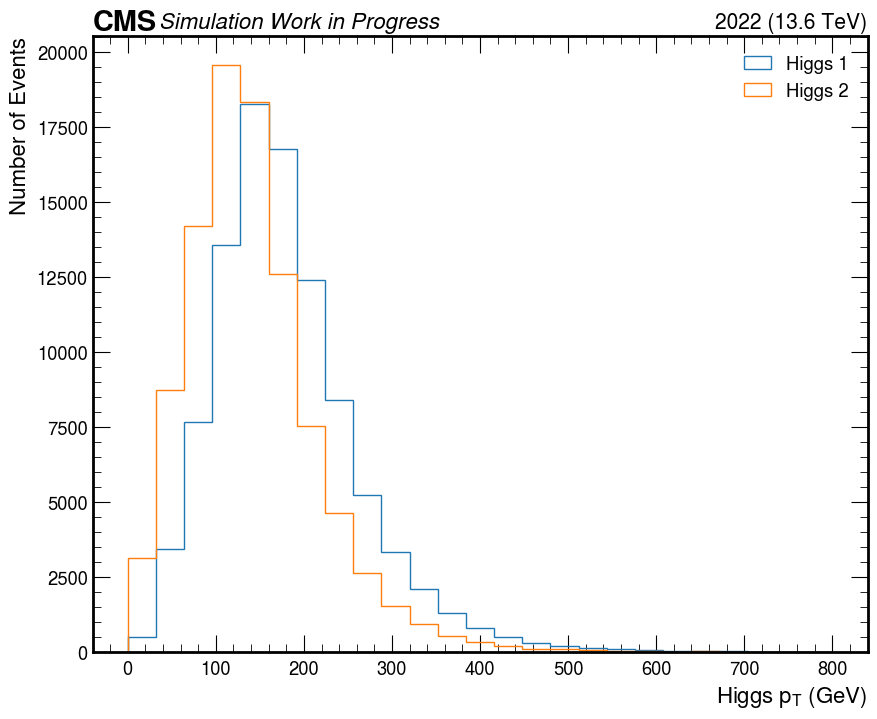

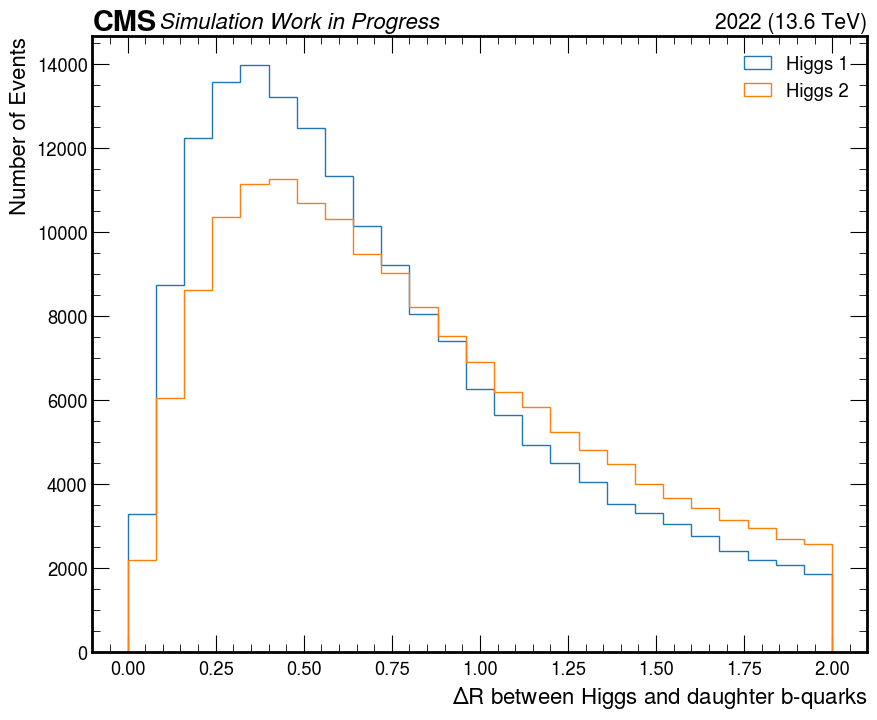

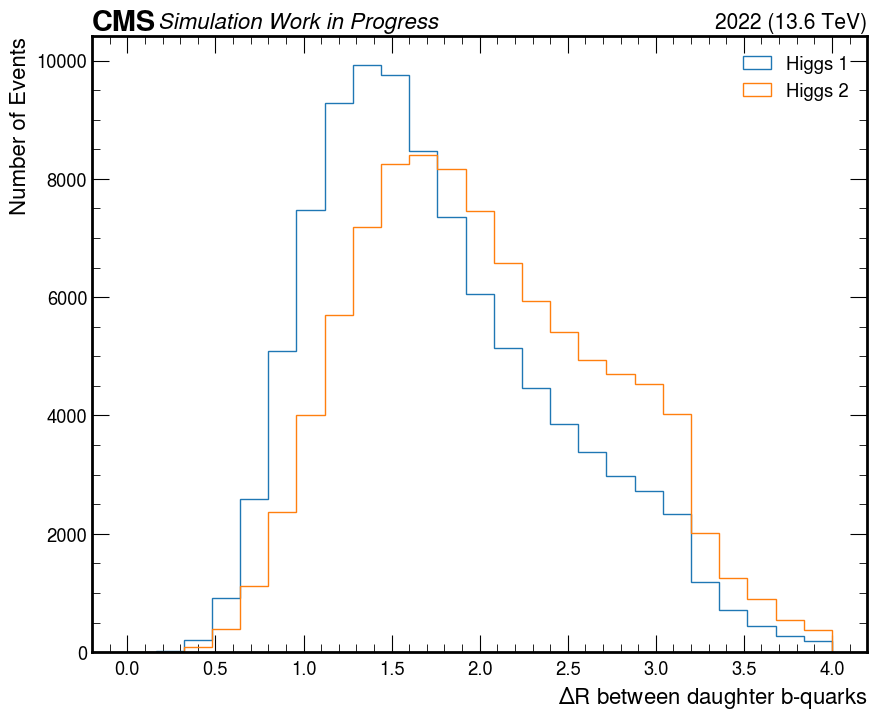

In [11]:
# plot Higgs pT
plot_higgs_hist(gen_higgs.pt, np.linspace(0, 800, 26), rf"Higgs $p_T$ (GeV)", "higgspt")
# plot Higgs-b-quark dR
plot_higgs_hist(
    bh_dR, np.linspace(0, 2, 26), rf"$\Delta R$ between Higgs and daughter $b$-quarks", "bh_dR"
)
# plot Higgs-b-quark dR
plot_higgs_hist(bs_dR, np.linspace(0, 4, 26), rf"$\Delta R$ between daughter $b$-quarks", "bs_dR")

## 2D histograms

### 2D histogram of dR between b-quarks vs Higgs pT

In [12]:
def plot_higgs_hist2d(
        x_vals: np.ndarray,
        y_vals: np.ndarray,
        bins: [np.ndarray, np.ndarray],
        x_label: str,
        y_label: str,
        filename: str,
):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    for i in range(2):
        ax[i].hist2d(x_vals[:, i].reshape(-1),
                     y_vals[:, i].reshape(-1),
                     bins,
                    )
        ax[i].set_xlabel(x_label)
        ax[i].set_ylabel(y_label)
        ax[i].set_title(f"Higgs {i + 1}")
        
    # hep.cms.label("Work in Progress", year="2022", com="13.6", ax=ax)
    plt.savefig(f"{plot_dir}/{filename}.jpg", bbox_inches="tight")
    plt.show()

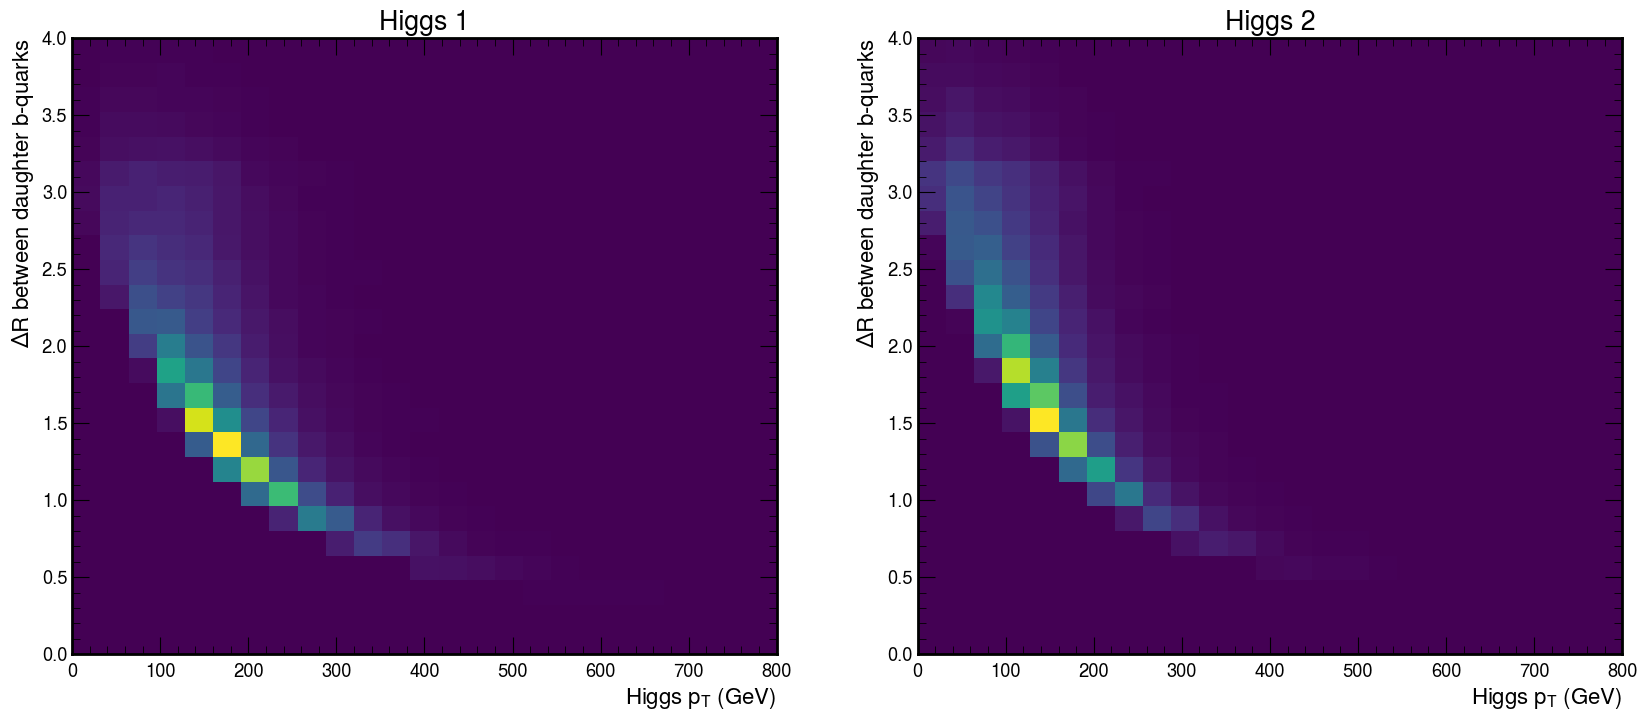

In [13]:
plot_higgs_hist2d(
    x_vals=gen_higgs.pt,
    y_vals=bs_dR,
    bins=[np.linspace(0, 800, 26), np.linspace(0, 4, 26)],
    x_label=rf"Higgs $p_T$ (GeV)",
    y_label=rf"$\Delta R$ between daughter $b$-quarks",
    filename="bs_DR_vs_higgspt",
)

### 2D histogram of Higgs pT vs matched fatjet pT (if it exists)

In [14]:
# get events and fatjets
events = pd.read_parquet(
    "../../../parquet/out_0.parquet"
    # "/eos/uscms/store/user/cmantill/bbbb/matching/Aug8/2022/GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_TSG/parquet"
)
fjs = make_vector(events, "ak8FatJet")
gen_higgs = make_vector(events, "GenHiggs")

N_event_bf_filter = gen_higgs.shape[0]

# filter out events that have multiple fatjets matched with 1 higgs
filter_fj = np.logical_or(
    (events['ak8FatJetHiggsMatchIndex'].to_numpy()==0).sum(axis=1)>1,
    (events['ak8FatJetHiggsMatchIndex'].to_numpy()==1).sum(axis=1)>1
)
events=events[~filter_fj]
fjs=fjs[~filter_fj]
gen_higgs=gen_higgs[~filter_fj]

N_event_af_filter = gen_higgs.shape[0]

print(f"Number of overlapped (AK8) events events: {N_event_bf_filter-N_event_af_filter}")
print(f"Percentage of uniquely assigned (AK8) events: {N_event_af_filter/N_event_bf_filter}")


# get fjs matched to higgs
matched_w_h1 = events['ak8FatJetHiggsMatchIndex']==0
matched_w_h2 = events['ak8FatJetHiggsMatchIndex']==1
fj_mwh1 = fjs[matched_w_h1]
fj_mwh2 = fjs[matched_w_h2]

# get higgs that are matched to fjs
event_matched_w_h1 = np.any(matched_w_h1==True, axis=1)
event_matched_w_h2 = np.any(matched_w_h2==True, axis=1)

h1 = gen_higgs[:,0]
h2 = gen_higgs[:,1]

h1_mwfj = h1[event_matched_w_h1]
h2_mwfj = h2[event_matched_w_h2]

Number of overlapped (AK8) events events: 46
Percentage of uniquely assigned (AK8) events: 0.9995170502267764


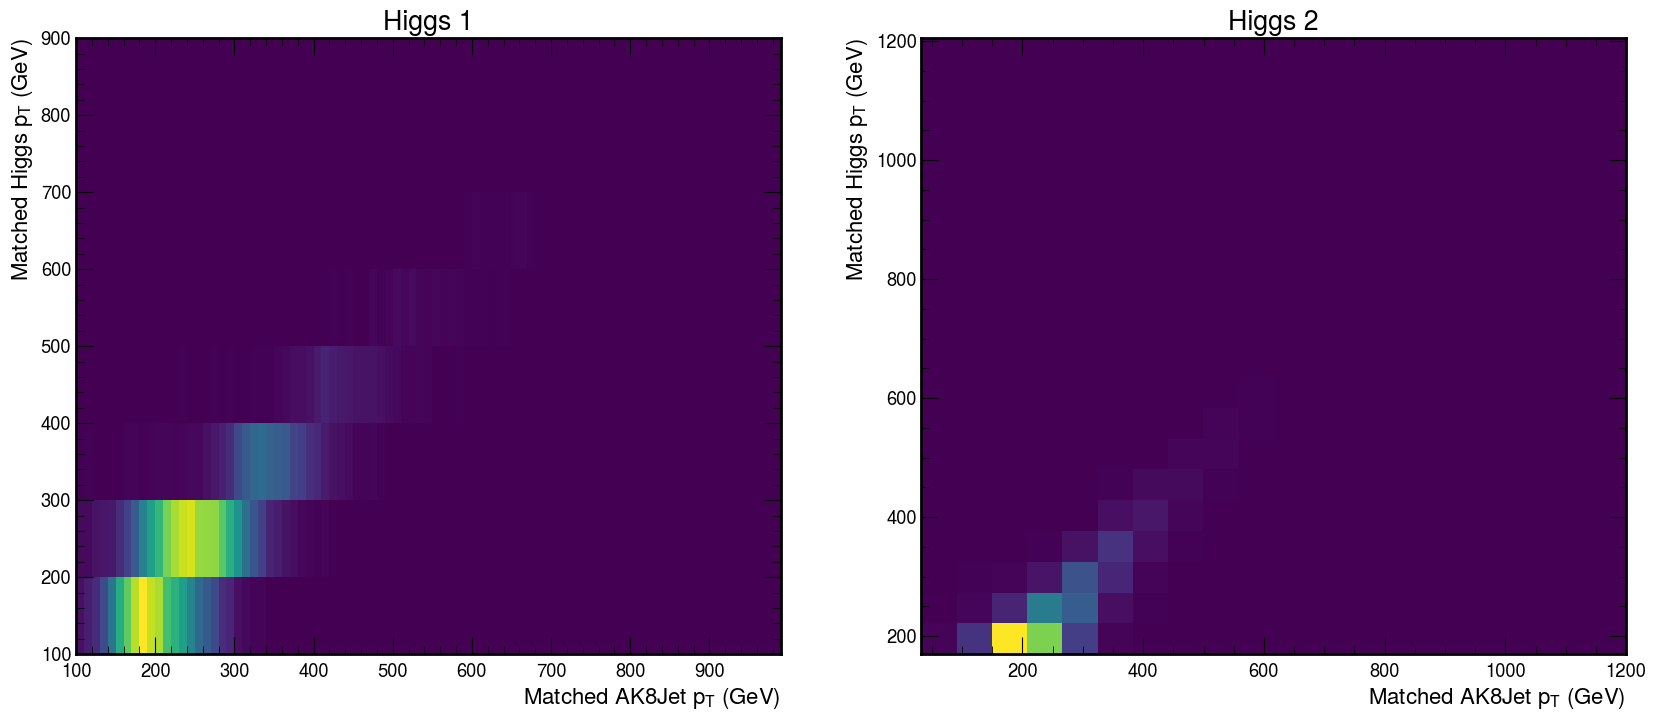

In [15]:
# plot
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

ax[0].hist2d(h1_mwfj.pt.reshape(-1),
             fj_mwh1.pt.reshape(-1),
             (np.arange(100,1000,10),np.arange(100,1000,100)),
            )

ax[1].hist2d(h2_mwfj.pt.reshape(-1),
             fj_mwh2.pt.reshape(-1),
             (20,20),
            )
ax[0].set_xlabel(rf'Matched AK8Jet $p_T$ (GeV)')
ax[0].set_ylabel(rf'Matched Higgs $p_T$ (GeV)')
ax[0].set_title(f"Higgs 1")

ax[1].set_xlabel(rf'Matched AK8Jet $p_T$ (GeV)')
ax[1].set_ylabel(rf'Matched Higgs $p_T$ (GeV)')
ax[1].set_title(f"Higgs 2")
        
    # hep.cms.label("Work in Progress", year="2022", com="13.6", ax=ax)
plt.savefig(f"{plot_dir}/H_pt_vs_fj_pt.jpg", bbox_inches="tight")
plt.show()

# color map legend

### 2D histogram of dR between b-quarks from H1 and b-quarks from H2

In [16]:
#get events
events = pd.read_parquet(
    "../../../parquet/out_0.parquet"
    # "/eos/uscms/store/user/cmantill/bbbb/matching/Aug8/2022/GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_TSG/parquet"
)
gen_higgs = make_vector(events, "GenHiggs")
# gen_bs shape: [# events, # Higgs (2), # b's (2)]
gen_bs = make_vector(events, "Genb").reshape(-1, 2, 2)

# sort higgs by pT
pt_argsort = np.argsort(gen_higgs.pt, axis=1)[:, ::-1]
gen_higgs = np.take_along_axis(gen_higgs, pt_argsort, 1)
# need to use np.newaxis to have same # of dimensions as gen_higgs (broadcasting)
gen_bs = np.take_along_axis(gen_bs, pt_argsort[..., np.newaxis], 1)
bh_dR = gen_bs.deltaR(gen_higgs[..., np.newaxis])
print(gen_bs.shape)
bs_dR = gen_bs[:, :, 0].deltaR(gen_bs[:, :, 1])

(95248, 2, 2)


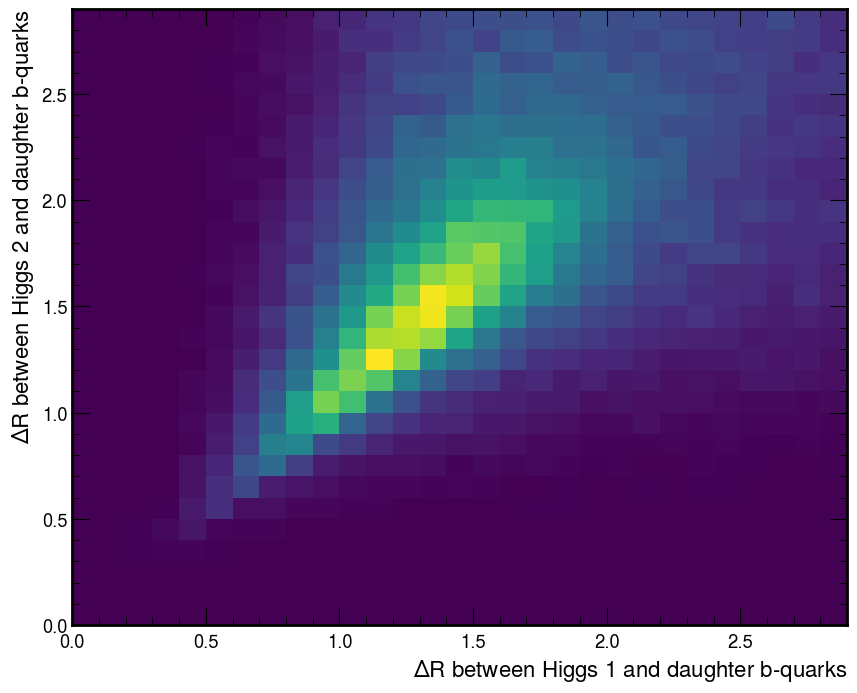

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.hist2d(bs_dR[:,0].reshape(-1),
            bs_dR[:,1].reshape(-1),
             (np.arange(0,3,0.1),np.arange(0,3,0.1)),
            )

ax.set_xlabel(rf"$\Delta R$ between Higgs 1 and daughter $b$-quarks")
ax.set_ylabel(rf"$\Delta R$ between Higgs 2 and daughter $b$-quarks")
        
# hep.cms.label("Work in Progress", year="2022", com="13.6", ax=ax)
plt.savefig(f"{plot_dir}/bh_dR_H1_vs_H2.jpg", bbox_inches="tight")
plt.show()

### AK8FatJet pT distribution

(array([    0,  8641, 10550,  3098,   793,   229,    84]), array([  0, 100, 200, 300, 400, 500, 600, 700]))
(array([12918, 50755, 23984,  5700,  1314,   372,   140]), array([  0, 100, 200, 300, 400, 500, 600, 700]))


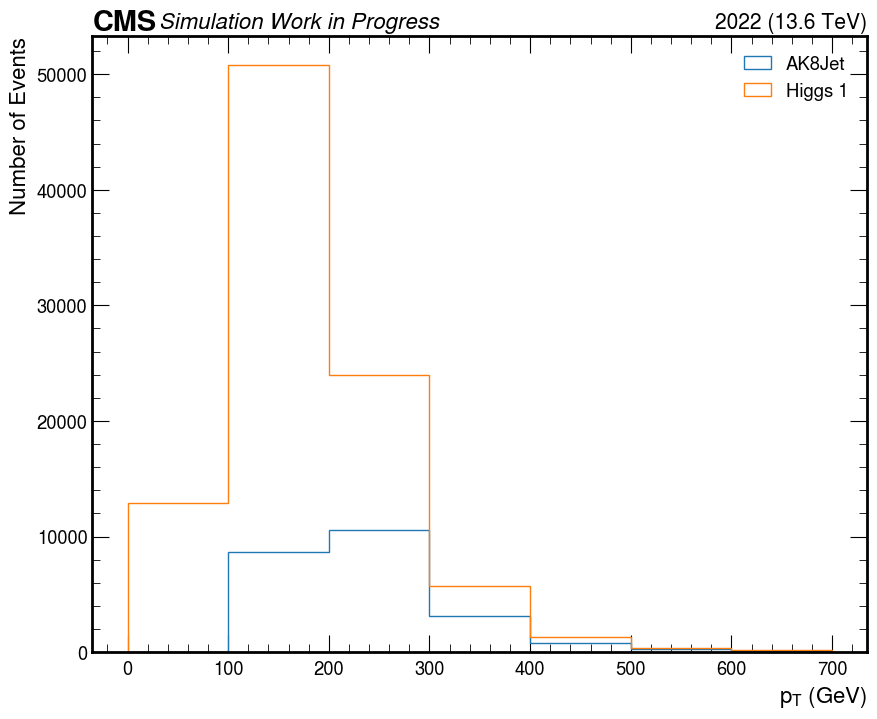

In [18]:
fig, ax = plt.subplots(figsize=(10,8))
ax.hist(fj_mwh1.pt, bins=np.arange(0,800,100), histtype="step", label=f"AK8Jet")
ax.hist(gen_higgs[:,0].pt, bins=np.arange(0,800,100), histtype="step", label=f"Higgs 1")
ax.legend()
hep.cms.label("Work in Progress", year="2022", com="13.6", ax=ax)
ax.set_xlabel(rf"$p_T$ (GeV)")
ax.set_ylabel(rf"Number of Events")

print(np.histogram(fj_mwh1.pt, bins=np.arange(0,800,100)))
print(np.histogram(gen_higgs[:,0].pt, bins=np.arange(0,800,100)))

(23432,)


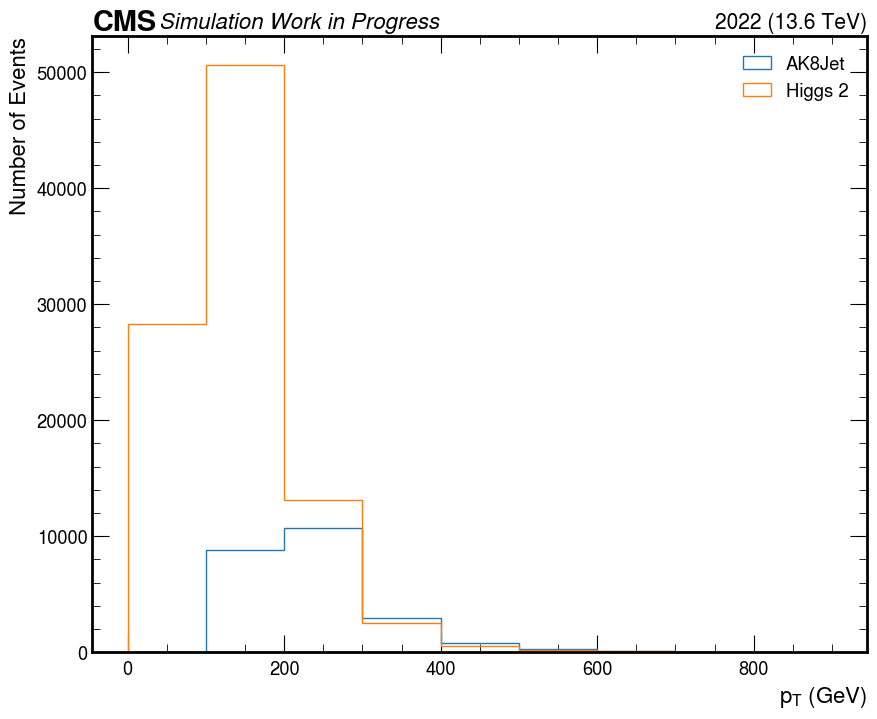

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(fj_mwh2.pt, bins=np.arange(0,1000,100), histtype="step", label=f"AK8Jet")
ax.hist(gen_higgs[:,1].pt, bins=np.arange(0,1000,100), histtype="step", label=f"Higgs 2")
ax.legend()
hep.cms.label("Work in Progress", year="2022", com="13.6", ax=ax)
ax.set_xlabel(rf"$p_T$ (GeV)")
ax.set_ylabel(rf"Number of Events")

print(fj_mwh1.shape)

### Matching efficiency by pT (uniquely assigned Higgs)

### Get jets that are matched to h1 and h2

In [20]:
# match resolved jets to Higgs
# get events and jets
events = pd.read_parquet(
    "../../../parquet/out_0.parquet"
    # "/eos/uscms/store/user/cmantill/bbbb/matching/Aug8/2022/GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_TSG/parquet"
)
jets = make_vector(events, "ak4Jet")
gen_higgs = make_vector(events, "GenHiggs")

N_event_bf_filter = gen_higgs.shape[0]

# filter out events that have multiple jets matched with 1 higgs
filter_j = np.logical_or(
    (events['ak4JetHiggsMatchIndex'].to_numpy()==0).sum(axis=1)>6,
    (events['ak4JetHiggsMatchIndex'].to_numpy()==1).sum(axis=1)>6,
)

events=events[~filter_j]
jets=jets[~filter_j]
gen_higgs=gen_higgs[~filter_j]

N_event_af_filter = gen_higgs.shape[0]

print(f"Number of 2-AK4-matched events events: {N_event_bf_filter-N_event_af_filter}")
print(f"Percentage of uniquely assigned (AK4) events: {N_event_af_filter/N_event_bf_filter}")


# get fjs matched to higgs
matched_w_h1 = events['ak4JetHiggsMatchIndex'].to_numpy()==0
matched_w_h2 = events['ak4JetHiggsMatchIndex'].to_numpy()==1
jet_mwh1 = jets[matched_w_h1]
jet_mwh2 = jets[matched_w_h2]

# get higgs that are matched to fjs
event_matched_w_h1 = np.any(matched_w_h1==True, axis=1)
event_matched_w_h2 = np.any(matched_w_h2==True, axis=1)

h1 = gen_higgs[:,0]
h2 = gen_higgs[:,1]

h1_mwj = h1[event_matched_w_h1]
h2_mwj = h2[event_matched_w_h2]

Number of 2-AK4-matched events events: 0
Percentage of uniquely assigned (AK4) events: 1.0


### get fjets that are matched to h1 and h2

In [21]:
# get events and fatjets
events = pd.read_parquet(
    "../../../parquet/out_0.parquet"
    # "/eos/uscms/store/user/cmantill/bbbb/matching/Aug8/2022/GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_TSG/parquet"
)
fjs = make_vector(events, "ak8FatJet")
gen_higgs = make_vector(events, "GenHiggs")

N_event_bf_filter = gen_higgs.shape[0]

# filter out events that have multiple fatjets matched with 1 higgs
filter_fj = np.logical_or(
    (events['ak8FatJetHiggsMatchIndex'].to_numpy()==0).sum(axis=1)>1,
    (events['ak8FatJetHiggsMatchIndex'].to_numpy()==1).sum(axis=1)>1
)
events=events[~filter_fj]
fjs=fjs[~filter_fj]
gen_higgs=gen_higgs[~filter_fj]

N_event_af_filter = gen_higgs.shape[0]

print(f"Number of overlapped (AK8) events events: {N_event_bf_filter-N_event_af_filter}")
print(f"Percentage of uniquely assigned (AK8) events: {N_event_af_filter/N_event_bf_filter}")


# get fjs matched to higgs
matched_w_h1 = events['ak8FatJetHiggsMatchIndex']==0
matched_w_h2 = events['ak8FatJetHiggsMatchIndex']==1
fj_mwh1 = fjs[matched_w_h1]
fj_mwh2 = fjs[matched_w_h2]

# get higgs that are matched to fjs
event_matched_w_h1 = np.any(matched_w_h1==True, axis=1)
event_matched_w_h2 = np.any(matched_w_h2==True, axis=1)

h1 = gen_higgs[:,0]
h2 = gen_higgs[:,1]

h1_mwfj = h1[event_matched_w_h1]
h2_mwfj = h2[event_matched_w_h2]

Number of overlapped (AK8) events events: 46
Percentage of uniquely assigned (AK8) events: 0.9995170502267764


### Plot ak4 and ak8 jet matching efficiency for h1

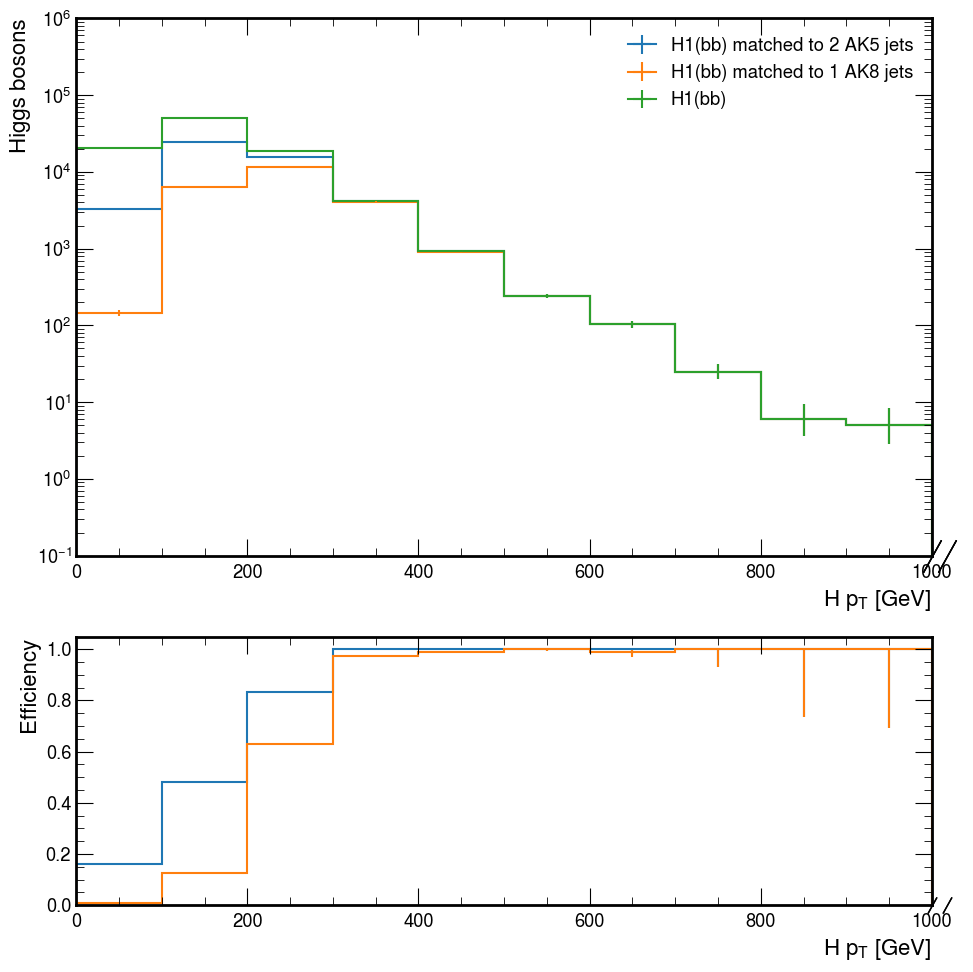

In [22]:
N_bin = 10

# fj matched 
events = pd.read_parquet(
    "../../../parquet/out_0.parquet"
    # "/eos/uscms/store/user/cmantill/bbbb/matching/Aug8/2022/GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_TSG/parquet"
)
gen_higgs = make_vector(events, "GenHiggs")
higgs_pt = hist.Hist.new.Reg(N_bin, 0, 1000, name=r"H $p_T$ [GeV]").Double()
higgs_pt.fill(gen_higgs[:,0].pt)

fj_higgs_pt = hist.Hist.new.Reg(N_bin, 0, 1000, name=r"H $p_T$ [GeV]").Double()
fj_higgs_pt.fill(h1_mwfj.pt)

j_higgs_pt = hist.Hist.new.Reg(N_bin, 0, 1000, name=r"H $p_T$ [GeV]").Double()
j_higgs_pt.fill(h1_mwj.pt)

j_ratio = j_higgs_pt / higgs_pt
j_ratio_h1 = j_ratio
j_ratio_uncert = np.abs(clopper_pearson_interval(num=j_higgs_pt.values(), denom=higgs_pt.values()) - j_ratio)
fj_ratio = fj_higgs_pt / higgs_pt
fj_ratio_uncert = np.abs(clopper_pearson_interval(num=fj_higgs_pt.values(), denom=higgs_pt.values()) - fj_ratio)



fig, axs = plt.subplots(2, 1, height_ratios=[2, 1])
hep.histplot(j_higgs_pt, label="H1(bb) matched to 2 AK5 jets", ax=axs[0])
hep.histplot(fj_higgs_pt, label="H1(bb) matched to 1 AK8 jets", ax=axs[0])
hep.histplot(higgs_pt, label="H1(bb)", ax=axs[0])
axs[0].set_ylabel("Higgs bosons")
axs[0].set_xlim(0, 1000)
axs[0].set_ylim(1e-1, 1e6)
axs[0].semilogy()
axs[0].legend(loc="upper right")
hep.histplot(
    j_ratio,
    yerr=j_ratio_uncert,
    label="H(bb) matched to 2 AK5 jets",
    ax=axs[1],
)
hep.histplot(
    fj_ratio,
    yerr=fj_ratio_uncert,
    label="H(bb) matched to 1 AK8 jets",
    ax=axs[1],
)
axs[1].set_ylabel("Efficiency")
axs[1].set_xlim(0, 1000)
plt.tight_layout()
plt.savefig(f"{plot_dir}/matching_eff_H1.jpg")

### plot ak4 and ak8 jet effiency for h2

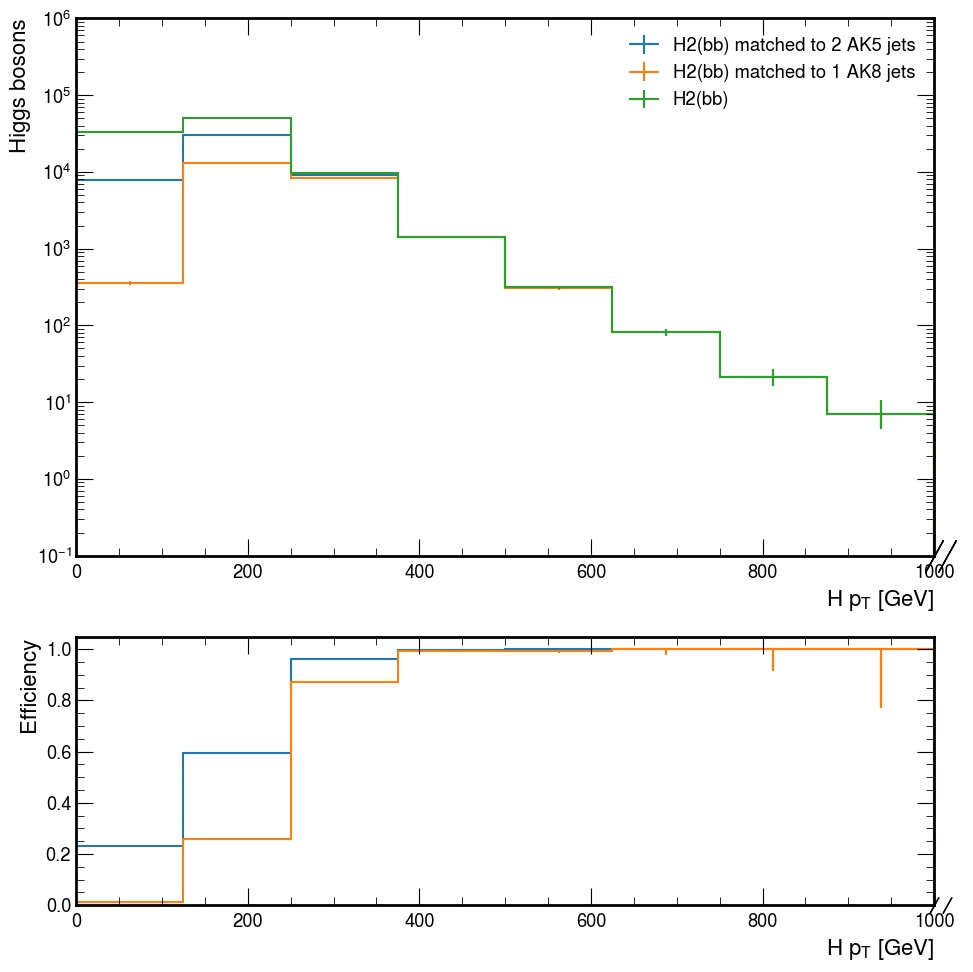

In [23]:
# fj matched 
N_bin = 8
events = pd.read_parquet(
    "../../../parquet/out_0.parquet"
    # "/eos/uscms/store/user/cmantill/bbbb/matching/Aug8/2022/GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_TSG/parquet"
)
gen_higgs = make_vector(events, "GenHiggs")
higgs_pt = hist.Hist.new.Reg(N_bin, 0, 1000, name=r"H $p_T$ [GeV]").Double()
higgs_pt.fill(gen_higgs[:,1].pt)

fj_higgs_pt = hist.Hist.new.Reg(N_bin, 0, 1000, name=r"H $p_T$ [GeV]").Double()
fj_higgs_pt.fill(h2_mwfj.pt)

j_higgs_pt = hist.Hist.new.Reg(N_bin, 0, 1000, name=r"H $p_T$ [GeV]").Double()
j_higgs_pt.fill(h2_mwj.pt)


j_ratio = j_higgs_pt / higgs_pt
j_ratio_h2 = j_ratio
j_ratio_uncert = np.abs(clopper_pearson_interval(num=j_higgs_pt.values(), denom=higgs_pt.values()) - j_ratio)
fj_ratio = fj_higgs_pt / higgs_pt
fj_ratio_uncert = np.abs(clopper_pearson_interval(num=fj_higgs_pt.values(), denom=higgs_pt.values()) - fj_ratio)



fig, axs = plt.subplots(2, 1, height_ratios=[2, 1])
hep.histplot(j_higgs_pt, label="H2(bb) matched to 2 AK5 jets", ax=axs[0])
hep.histplot(fj_higgs_pt, label="H2(bb) matched to 1 AK8 jets", ax=axs[0])
hep.histplot(higgs_pt, label="H2(bb)", ax=axs[0])
axs[0].set_ylabel("Higgs bosons")
axs[0].set_xlim(0, 1000)
axs[0].set_ylim(1e-1, 1e6)
axs[0].semilogy()
axs[0].legend(loc="upper right")
hep.histplot(
    j_ratio,
    yerr=j_ratio_uncert,
    label="H(bb) matched to 2 AK5 jets",
    ax=axs[1],
)
hep.histplot(
    fj_ratio,
    yerr=fj_ratio_uncert,
    label="H(bb) matched to 1 AK8 jets",
    ax=axs[1],
)
axs[1].set_ylabel("Efficiency")
axs[1].set_xlim(0, 1000)
plt.tight_layout()
plt.savefig(f"{plot_dir}/matching_eff_H2.jpg")

## Average mass resolution ((jet mass - higgs mass) / higgs mass ) vs pT

### To calculate mass of 2 ak4 jets, find every higgs that are matched to only 2 ak4 jets
### Note: At event level, we only keep the events that have h1 and/or h2 matched with 2 b jets 

In [24]:
events = pd.read_parquet(
    "../../../parquet/out_0.parquet"
    # "/eos/uscms/store/user/cmantill/bbbb/matching/Aug8/2022/GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_TSG/parquet"
)
jets = make_vector(events, "ak4Jet")
gen_higgs = make_vector(events, "GenHiggs")

N_event_bf_filter = gen_higgs.shape[0]

# filter out events that have 2 ak4 jets matched to h1/h2
event_matched_w_h1 = (events['ak4JetHiggsMatchIndex'].to_numpy()==0).sum(axis=1)==2 # event matched
jet_mwh1 = jets[event_matched_w_h1]
matched_w_h1 = (events['ak4JetHiggsMatchIndex'].to_numpy()==0)[event_matched_w_h1] # jet indices in the matched events
jet_mwh1 = jet_mwh1[matched_w_h1].reshape(-1, 2)
h1_mwj = gen_higgs[event_matched_w_h1][:,0]

event_matched_w_h2 = (events['ak4JetHiggsMatchIndex'].to_numpy()==1).sum(axis=1)==2
jet_mwh2 = jets[event_matched_w_h2]
matched_w_h2 = (events['ak4JetHiggsMatchIndex'].to_numpy()==1)[event_matched_w_h2]
jet_mwh2 = jet_mwh2[matched_w_h2].reshape(-1, 2)
h2_mwj = gen_higgs[event_matched_w_h2][:,1]

### Then get fatjets (obtained in previous cell)

In [25]:
# get events and fatjets
events = pd.read_parquet(
    "../../../parquet/out_0.parquet"
    # "/eos/uscms/store/user/cmantill/bbbb/matching/Aug8/2022/GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_TSG/parquet"
)
fjs = make_vector(events, "ak8FatJet")
gen_higgs = make_vector(events, "GenHiggs")

N_event_bf_filter = gen_higgs.shape[0]

# filter out events that have 2 ak4 jets matched to h1/h2
event_matched_w_h1 = (events['ak8FatJetHiggsMatchIndex'].to_numpy()==0).sum(axis=1)==1 # event matched
fj_mwh1 = fjs[event_matched_w_h1]
matched_w_h1 = (events['ak8FatJetHiggsMatchIndex'].to_numpy()==0)[event_matched_w_h1] # jet indices in the matched events
fj_mwh1 = fj_mwh1[matched_w_h1]
h1_mwfj = gen_higgs[event_matched_w_h1][:,0]

event_matched_w_h2 = (events['ak8FatJetHiggsMatchIndex'].to_numpy()==1).sum(axis=1)==1 # event matched
fj_mwh2 = fjs[event_matched_w_h2]
matched_w_h2 = (events['ak8FatJetHiggsMatchIndex'].to_numpy()==1)[event_matched_w_h2] # jet indices in the matched events
fj_mwh2 = fj_mwh2[matched_w_h2]
h2_mwfj = gen_higgs[event_matched_w_h2][:,1]

### Plot ak4 and ak8 average mass resolution for H1

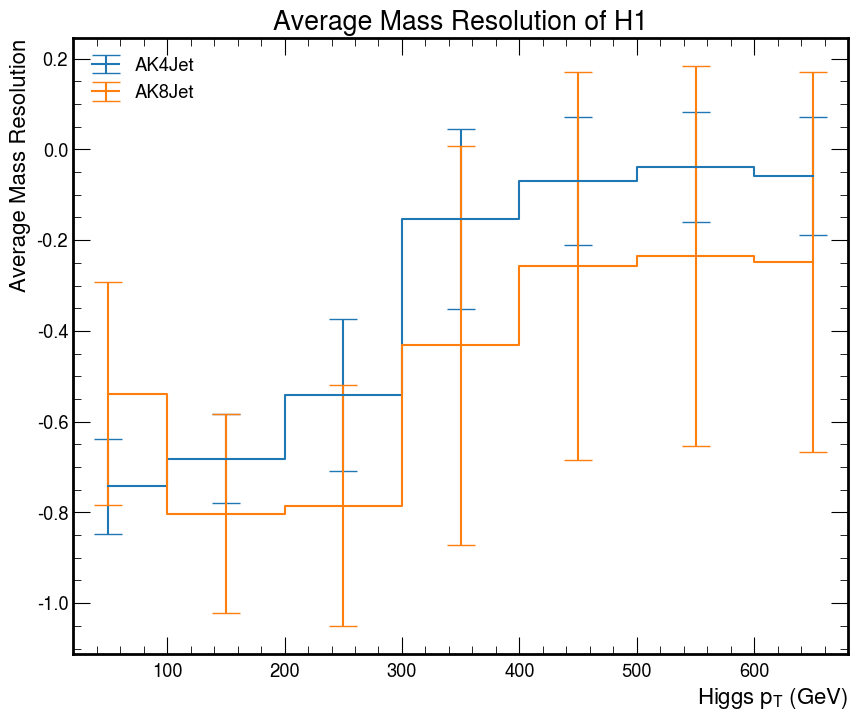

In [26]:
# calculate mass of every matched pair of ak4 jets
jet_mwh1_mass = (jet_mwh1[:,0]+jet_mwh1[:,1]).m
fj_mwh1_mass = fj_mwh1.m

h1_mwj_mass = h1_mwj.m
h1_mwfj_mass = h1_mwfj.m

h1_mwj_pt = h1_mwj.pt
h1_mwfj_pt = h1_mwfj.pt

res_jet = (jet_mwh1_mass-h1_mwj_mass)/h1_mwj_mass
res_fj = (fj_mwh1_mass-h1_mwfj_mass)/h1_mwfj_mass

bins = np.arange(0,800,100)
bin_centers = []
res_jet_per_bin = []
res_fj_per_bin = []

for i in range(0, bins.shape[0]-1):
    edge_left = bins[i]
    edge_right = bins[i+1]
    bin_centers.append((edge_left+edge_right)/2)
    res_jet_per_bin.append(res_jet[np.logical_and(h1_mwj_pt>edge_left, h1_mwj_pt<edge_right)])
    res_fj_per_bin.append(res_fj[np.logical_and(h1_mwfj_pt>edge_left, h1_mwfj_pt<edge_right)])
    
res_jet_steps = [res.mean() for res in res_jet_per_bin]
res_fj_steps = [res.mean() for res in res_fj_per_bin]

res_jet_err = [res.std() for res in res_jet_per_bin]
res_fj_err = [res.std() for res in res_fj_per_bin]

fig, ax = plt.subplots(figsize=(10, 8))
ax.errorbar(x=bin_centers, y=res_jet_steps, yerr=res_jet_err, label=f"AK4Jet", drawstyle='steps-mid', capsize=10)#,barsabove=True)
ax.errorbar(x=bin_centers, y=res_fj_steps, yerr=res_fj_err, label=f"AK8Jet", drawstyle='steps-mid', capsize=10)
ax.legend()
# hep.cms.label("Work in Progress", year="2022", com="13.6", ax=ax)
ax.set_title(rf"Average Mass Resolution of H1")
ax.set_xlabel(rf"Higgs $p_T$ (GeV)")
ax.set_ylabel(rf"Average Mass Resolution")
plt.savefig(f"{plot_dir}/res_H1.jpg")

### Plot ak4 and ak8 average mass resolution for H2

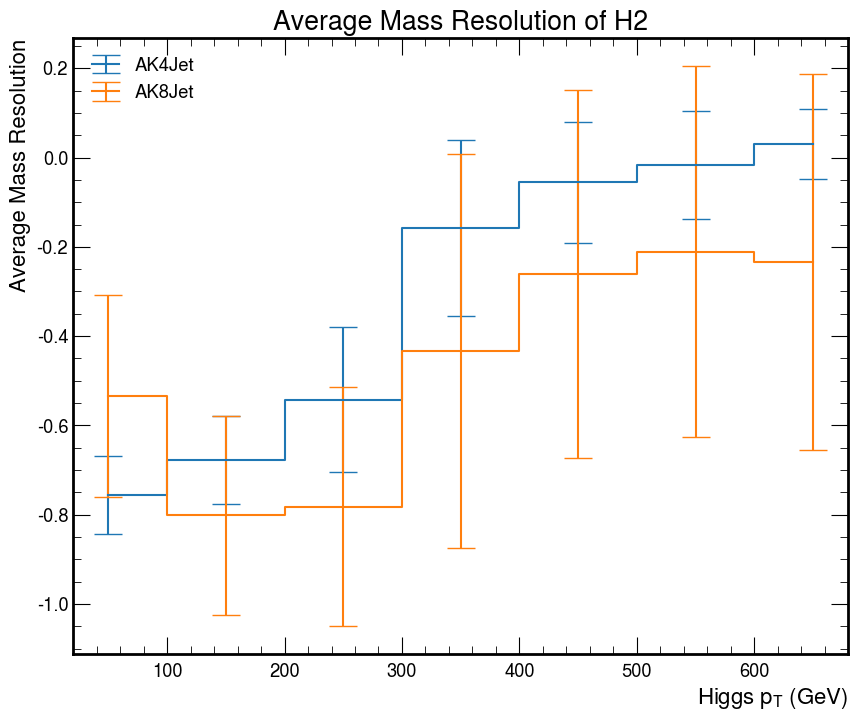

In [27]:
# calculate mass of every matched pair of ak4 jets
jet_mwh2_mass = (jet_mwh2[:,0]+jet_mwh2[:,1]).m
fj_mwh2_mass = fj_mwh2.m

h2_mwj_mass = h2_mwj.m
h2_mwfj_mass = h2_mwfj.m

h2_mwj_pt = h2_mwj.pt
h2_mwfj_pt = h2_mwfj.pt

res_jet = (jet_mwh2_mass-h2_mwj_mass)/h2_mwj_mass
res_fj = (fj_mwh2_mass-h2_mwfj_mass)/h2_mwfj_mass

bins = np.arange(0,800,100)
bin_centers = []
res_jet_per_bin = []
res_fj_per_bin = []

for i in range(0, bins.shape[0]-1):
    edge_left = bins[i]
    edge_right = bins[i+1]
    bin_centers.append((edge_left+edge_right)/2)
    res_jet_per_bin.append(res_jet[np.logical_and(h2_mwj_pt>edge_left, h2_mwj_pt<edge_right)])
    res_fj_per_bin.append(res_fj[np.logical_and(h2_mwfj_pt>edge_left, h2_mwfj_pt<edge_right)])
    
res_jet_steps = [res.mean() for res in res_jet_per_bin]
res_fj_steps = [res.mean() for res in res_fj_per_bin]

res_jet_err = [res.std() for res in res_jet_per_bin]
res_fj_err = [res.std() for res in res_fj_per_bin]

fig, ax = plt.subplots(figsize=(10, 8))
ax.errorbar(x=bin_centers, y=res_jet_steps, yerr=res_jet_err, label=f"AK4Jet", drawstyle='steps-mid', capsize=10)#,barsabove=True)
ax.errorbar(x=bin_centers, y=res_fj_steps, yerr=res_fj_err, label=f"AK8Jet", drawstyle='steps-mid', capsize=10)
ax.legend()
#hep.cms.label("Work in Progress", year="2022", com="13.6", ax=ax)
ax.set_title(rf"Average Mass Resolution of H2")
ax.set_xlabel(rf"Higgs $p_T$ (GeV)")
ax.set_ylabel(rf"Average Mass Resolution")
plt.savefig(f"{plot_dir}/res_H2.jpg")

### 2D efficiency Higgs1 vs Higgs2

### 1 for AK4

In [28]:
# ratio is defined by ratio = #_jet/#_higgs
# aka ratio of two 2d histogram

# 2d histogram needs the number of entries at each dimension matches with each other
# so we need to select events that have both higgs matched

# select events that have both H1 and H2
events = pd.read_parquet(
    "../../../parquet/out_0.parquet"
    # "/eos/uscms/store/user/cmantill/bbbb/matching/Aug8/2022/GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_TSG/parquet"
)
jets = make_vector(events, "ak4Jet")
gen_higgs = make_vector(events, "GenHiggs")

# filter out events that have both H matched to 
filter_j = np.logical_and(
    (events['ak4JetHiggsMatchIndex'].to_numpy()==0).sum(axis=1)==2,
    (events['ak4JetHiggsMatchIndex'].to_numpy()==1).sum(axis=1)==2,
)

events = events[filter_j]


In [29]:
jet_mwh1 = jets[filter_j]
jet_mwh2 = jets[filter_j]
matched_w_h1 = (events['ak4JetHiggsMatchIndex'].to_numpy()==0)[filte_j] # jet indices in the matched events
jet_mwh1 = jet_mwh1[matched_w_h1].reshape(-1, 2)
h1_mwj = gen_higgs[event_matched_w_h1][:,0]

j_ratio = j_higgs_pt / higgs_pt

NameError: name 'filte_j' is not defined

### 1 for AK8

In [ ]:
# get events and fatjets
events = pd.read_parquet(
    "../../../parquet/out_0.parquet"
    # "/eos/uscms/store/user/cmantill/bbbb/matching/Aug8/2022/GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_TSG/parquet"
)
fjs = make_vector(events, "ak8FatJet")
gen_higgs = make_vector(events, "GenHiggs")

N_event_bf_filter = gen_higgs.shape[0]

# filter out events that have multiple fatjets matched with 1 higgs
filter_fj = np.logical_or(
    (events['ak8FatJetHiggsMatchIndex'].to_numpy()==0).sum(axis=1)>1,
    (events['ak8FatJetHiggsMatchIndex'].to_numpy()==1).sum(axis=1)>1
)
events=events[~filter_fj]
fjs=fjs[~filter_fj]
gen_higgs=gen_higgs[~filter_fj]

N_event_af_filter = gen_higgs.shape[0]

print(f"Number of overlapped (AK8) events events: {N_event_bf_filter-N_event_af_filter}")
print(f"Percentage of uniquely assigned (AK8) events: {N_event_af_filter/N_event_bf_filter}")


# get fjs matched to higgs
matched_w_h1 = events['ak8FatJetHiggsMatchIndex']==0
matched_w_h2 = events['ak8FatJetHiggsMatchIndex']==1
fj_mwh1 = fjs[matched_w_h1]
fj_mwh2 = fjs[matched_w_h2]

# get higgs that are matched to fjs
event_matched_w_h1 = np.any(matched_w_h1==True, axis=1)
event_matched_w_h2 = np.any(matched_w_h2==True, axis=1)

h1 = gen_higgs[:,0]
h2 = gen_higgs[:,1]

h1_mwfj = h1[event_matched_w_h1]
h2_mwfj = h2[event_matched_w_h2]

In [ ]:
# plot
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

ax[0].hist2d(h1_mwfj.pt.reshape(-1),
             fj_mwh1.pt.reshape(-1),
             (np.arange(100,1000,10),np.arange(100,1000,100)),
            )

ax[1].hist2d(h2_mwfj.pt.reshape(-1),
             fj_mwh2.pt.reshape(-1),
             (20,20),
            )
ax[0].set_xlabel(rf'Matched AK8Jet $p_T$ (GeV)')
ax[0].set_ylabel(rf'Matched Higgs $p_T$ (GeV)')
ax[0].set_title(f"Higgs 1")

ax[1].set_xlabel(rf'Matched AK8Jet $p_T$ (GeV)')
ax[1].set_ylabel(rf'Matched Higgs $p_T$ (GeV)')
ax[1].set_title(f"Higgs 2")
        
    # hep.cms.label("Work in Progress", year="2022", com="13.6", ax=ax)
plt.savefig(f"{plot_dir}/H_pt_vs_fj_pt.jpg", bbox_inches="tight")
plt.show()

# color map legend

In [ ]:
j_ratio = j_higgs_pt / higgs_pt